# Importing all libraries

In [1]:
import time
import string
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.distributions import Normal, Binomial
from sklearn.model_selection import train_test_split
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


# Data Generator Class

In [2]:
class DataGenerator:
    def __init__(self, df, device, feature_lb = 0):
        self.df = df
        self.feature_lb = feature_lb
        self.device = torch.device(device)
        self.n = len(df)
        # Keeping only useful feature and target
        self.df = self.df[['overall','reviewText']]
        self.df = self.df.dropna()

        # Creating the vocabulary
        self.vocab = set()
        for review in self.df['reviewText']:
            self.vocab.update(self.preprocess(review))

        # Creating the word to dummy dataframe
        self.columns = list(self.vocab) + ['Constant', 'Rating']
        self.review_dummy = pd.DataFrame(0, index=np.arange(self.n), columns = self.columns)
        
        for i, (text, label) in enumerate(zip(self.df['reviewText'], self.df['overall'])):
            words = self.preprocess(text)
            for word in words:
                if word in self.vocab:
                    # Setting dummy variable to 1 is word is present
                    self.review_dummy.at[i, word] = 1
            # 'Constant' is for fitting the intercept
            self.review_dummy.at[i, 'Constant'] = 1
            self.review_dummy.at[i, 'Rating'] = label

        # Removing the words that occur less than feature_lb * total number of reviews times
        mean_values = self.review_dummy.mean()
        cols_to_drop = mean_values[mean_values < self.feature_lb].index.tolist()
        self.review_dummy.drop(columns = cols_to_drop, inplace = True)
        self.columns = list(self.review_dummy.columns)
        print(f"\nDataGenerator created : \n Number of reviews : {self.n} \n Number of features : {len(self.review_dummy.columns) - 1} \n Number of words removed : {len(cols_to_drop)}")

    def split_data(self, test_size=0.2, random_state=42):
        # Splitting the data into train and test sets
        self.X = self.review_dummy.drop(columns=['Rating'])
        self.y = self.review_dummy['Rating']
        self.X = torch.tensor(self.X.values, dtype=torch.float32).to(self.device)
        self.y = torch.tensor(self.y.values, dtype=torch.float32).to(self.device)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state = random_state)
        print(f"\nData split into train and test sets : \n Train set size : {len(self.X_train)} \n Test set size : {len(self.X_test)}")
        
    def preprocess(self, text):
        # Remove punctuation and lowercase the text and return the list of words using a translation table
        text = text.translate(str.maketrans('', '', string.punctuation)).lower()
        return text.split()

In [3]:
def load(filename):
        # Load a saved instance of the model from a file.
        with open(filename, 'rb') as file:
            instance = pickle.load(file)
        print(f"Model loaded from {filename}")
        return instance

# Writing Class for MCMC chain

In [4]:
class ProperBayes:
    def __init__(self, dataGenerator, prior_mu, prior_std):
        # Importing information from the DataGenerator class
        self.X_train = dataGenerator.X_train
        self.X_test = dataGenerator.X_test
        self.y_train = dataGenerator.y_train
        self.y_test = dataGenerator.y_test
        self.n_features = dataGenerator.X_train.shape[1]
        self.n_obs = dataGenerator.X_train.shape[0]
        self.feature_lb = dataGenerator.feature_lb
        self.device = dataGenerator.device
        self.columns = dataGenerator.columns
        self.prior_mu = prior_mu
        self.prior_std = prior_std
        # title for plots
        self.title = f"Prior on beta = Normal({self.prior_mu}, {self.prior_std**2:.4f}) \n"
        self.title += f"Feature Lowerbound = {self.feature_lb}, Number of features = {self.n_features} \n"
        
    def log_hastings(self):
        theta_proposal = self.X_train @ (self.beta_proposal).T
        theta_current = self.X_train @ (self.beta_current).T
        p_proposal = torch.sigmoid(theta_proposal)
        p_current = torch.sigmoid(theta_current)
        p_proposal = torch.clamp(p_proposal, 1e-6, 1 - 1e-6)
        p_current = torch.clamp(p_current, 1e-6, 1 - 1e-6)

        # Calculating likelihood after dropping the combination term
        log_lkl_proposal = ((self.y_train * torch.log(p_proposal)) + ((5 - self.y_train) * torch.log(1 - p_proposal))).sum()
        log_lkl_current = ((self.y_train * torch.log(p_current)) + ((5 - self.y_train) * torch.log(1 - p_current))).sum()

        # Calculating prior after dropping the 1/root(2pi)sigma coefficient term
        log_prior_proposal = -0.5 * (self.beta_proposal**2).sum() / (self.prior_std**2)
        log_prior_current = -0.5 * (self.beta_current**2).sum() / (self.prior_std**2)

        return log_lkl_proposal + log_prior_proposal - log_lkl_current - log_prior_current
    
    def predict(self, X_test, beta_sample):
        # Predicting the rating out of 5
        theta = X_test @ beta_sample.T
        p = torch.sigmoid(theta)
        p = torch.clamp(p, 1e-6, 1 - 1e-6)
        y_pred = Binomial(5, p).sample()
        return y_pred
    
    def give_accuracy(self):
        y_pred = self.predict(self.X_test, self.beta_estimate)
        self.accuracy = torch.mean((y_pred == self.y_test).float())
        print(f"Accuracy: {self.accuracy:.6f}")

    def fit(self, step_size, n_samp, n_burnin = None):
        if n_burnin is None: n_burnin = n_samp // 2
        self.n_burnin = n_burnin
        self.step_size = step_size
        self.n_samp = n_samp
        self.title += f"step_size = {self.step_size}, n_samp = {self.n_samp} \n"
        # Running MCMC to estimate the beta(parameter vector)
        select_count = 0
        chain_count = 0
        print_count = -1
        # Initializing the chain from the prior on beta
        self.beta_current = torch.normal(0, self.prior_std, size = (1,self.n_features), dtype=torch.float32).to(self.device)
        # Pre-allocate space for the chain of selected samples
        self.beta_samples = torch.zeros((n_samp, self.n_features), dtype=torch.float32).to(self.device)
        # Space for the chain of all samples
        self.beta_chain = self.beta_current
        start = time.time()
        print()
        while (select_count < n_samp):
            # Generate proposal
            self.beta_proposal = self.beta_current + torch.normal(0, step_size, size = self.beta_current.shape, device=self.device)

            # Compute Hastings ratio
            hastings_ratio = self.log_hastings()

            # Probabilistic rejection
            if (torch.log(torch.rand(1))).item() < min(0, hastings_ratio.item()):
                self.beta_current = self.beta_proposal
                self.beta_samples[select_count] = self.beta_current
                select_count += 1

            # Adding the proposal to all samples chain regardless of its selection
            self.beta_chain = torch.vstack((self.beta_chain, self.beta_proposal))
            chain_count += 1

            # Printing numbers to track the chain
            if (select_count//100 > print_count):
                print_count += 1
                print(f"Select Count: {select_count}, Chain Count: {chain_count}, time: {((time.time() - start)/60):.2f} minutes")

        self.acceptance_rate = select_count / chain_count
        print(f"\nAcceptance rate: {self.acceptance_rate:.4f}")
        print(f"GPU memory in use: {torch.cuda.memory_allocated()/1e6:.2f} MB")
        self.beta_estimate = self.beta_samples[n_burnin:,].mean(axis=0)
        self.give_accuracy()
        self.title += f"Acceptance rate: {self.acceptance_rate:.4f}, Accuracy: {self.accuracy:.4f}"

    def get_estimate(self, word):
        # Get the estimate of the beta for the given word
        col = self.columns.index(word)
        estimate = self.beta_estimate[col].item()
        print(f"Posterior estimate of beta_{col} i.e. \"{word}\" : {estimate:.4f}")
        return estimate

    def plot_hist(self, word):
        # Plotting the histogram of the posterior samples for the given word
        col = self.columns.index(word)
        plt.figure(figsize=(5, 3))
        plt.hist(self.beta_samples[self.n_burnin:, col].cpu().numpy(), bins=30, density=True, color='g')
        plt.title(self.title, fontsize=10)
        plt.xlabel(f'Posterior Distribution of beta_{col} i.e. \'{word}\'')
        plt.ylabel('Density')
        plt.grid(alpha=0.3)
        plt.show()

    def plot_trace(self, word):
        # Plotting the trace of the posterior samples for the given word
        col = self.columns.index(word)
        plt.figure(figsize=(5, 3))
        plt.plot(self.beta_chain[:, col].cpu().numpy(), color='g')
        plt.title(self.title, fontsize=10)
        plt.xlabel(f'Posterior Distribution of beta_{col} i.e. \'{word}\'')
        plt.ylabel('Trace')
        plt.grid(alpha=0.3)
        plt.show()

    def save(self):
        # Save the current instance of the model to a file.
        filename = f"MCMC_step={self.step_size}_n_samp={self.n_samp}" + ".pkl"
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model saved to {filename}")

# Writing Class for HMC chain

In [5]:
class ProperBayesHMC:
    def __init__(self, dataGenerator, prior_mu, prior_std):
        # Importing information from the DataGenerator class
        self.X_train = dataGenerator.X_train
        self.X_test = dataGenerator.X_test
        self.y_train = dataGenerator.y_train
        self.y_test = dataGenerator.y_test
        self.n_features = dataGenerator.X_train.shape[1]
        self.n_obs = dataGenerator.X_train.shape[0]
        self.feature_lb = dataGenerator.feature_lb
        self.device = dataGenerator.device
        self.columns = dataGenerator.columns
        self.prior_mu = prior_mu
        self.prior_std = prior_std

        # Title for plots
        self.title = f"Prior on beta = Normal({self.prior_mu}, {self.prior_std**2:.4f}) \n"
        self.title += f"Feature Lowerbound = {self.feature_lb}, Number of features = {self.n_features} \n"

    def energy(self, beta):
        # Calculate the energy of the system: -log(posterior)
        theta = self.X_train @ beta.T
        p = torch.sigmoid(theta)
        p = torch.clamp(p, 1e-6, 1 - 1e-6)

        log_likelihood = ((self.y_train * torch.log(p)) + ((5 - self.y_train) * torch.log(1 - p))).sum()
        log_prior = -0.5 * (beta**2).sum() / (self.prior_std**2)

        return - (log_likelihood + log_prior)

    def gradient_energy(self, beta):
        beta = beta.view(-1, 1)  # Ensure beta is 2D for matrix multiplication
        theta = self.X_train @ beta
        p = torch.sigmoid(theta).view(-1)  # Reshape to 1D tensor
        grad_likelihood = self.X_train.T @ (self.y_train - 5 * p)
        grad_prior = -beta.view(-1) / (self.prior_std**2)  # Reshape beta back to 1D
        return -(grad_likelihood + grad_prior)

    def leap_frog(self, beta, momentum, step_size, L):
        # Perform L leapfrog steps
        momentum -= 0.5 * step_size * self.gradient_energy(beta)
        for _ in range(L):
            beta += step_size * momentum
            if _ < L - 1:  # Full steps for momentum except for the last iteration
                momentum -= step_size * self.gradient_energy(beta)
        momentum -= 0.5 * step_size * self.gradient_energy(beta)  # Final half step for momentum

        return beta, momentum

    def fit(self, step_size, L, n_samp, n_burnin=None):
        if n_burnin is None:
            n_burnin = n_samp // 2

        self.step_size = step_size
        self.L = L
        self.n_samp = n_samp
        self.n_burnin = n_burnin
        self.title += f"step_size = {self.step_size}, L = {self.L}, n_samp = {self.n_samp} \n"

        # Initializing the chain
        beta_current = torch.normal(0, self.prior_std, size=(1, self.n_features), dtype=torch.float32).to(self.device)
        self.beta_samples = torch.zeros((n_samp, self.n_features), dtype=torch.float32).to(self.device)
        self.beta_chain = beta_current
        chain_count = 0
        accept_count = 0
        print_count = -1

        start = time.time()
        while (accept_count < n_samp):
            # Sample random momentum
            momentum_current = torch.normal(0, 1, size=beta_current.shape, device=self.device)

            # Perform leapfrog steps
            beta_proposal, momentum_proposal = self.leap_frog(beta_current.clone(), momentum_current.clone(), step_size, L)

            # Compute energy
            energy_current = self.energy(beta_current) + 0.5 * (momentum_current**2).sum()
            energy_proposal = self.energy(beta_proposal) + 0.5 * (momentum_proposal**2).sum()

            # Metropolis acceptance criterion
            if torch.rand(1).item() < torch.exp(energy_current - energy_proposal).item():
                beta_current = beta_proposal
                self.beta_samples[accept_count] = beta_current
                accept_count += 1

            # Storing all proposals
            self.beta_chain = torch.vstack([self.beta_chain, beta_proposal])
            chain_count += 1

            # Printing numbers to track the chain
            if (accept_count//100 > print_count):
                print_count += 1
                print(f"Accept Count: {accept_count}, Chain Count: {chain_count}, time: {((time.time() - start)/60):.2f} minutes")


        self.acceptance_rate = accept_count / chain_count
        self.beta_estimate = self.beta_samples[n_burnin:, ].mean(axis=0)

        print(f"\nAcceptance rate: {self.acceptance_rate:.4f}")
        print(f"Time elapsed: {(time.time() - start)/60:.2f} minutes")
        print(f"GPU memory in use: {torch.cuda.memory_allocated()/1e6:.2f} MB")
        self.give_accuracy()
        self.title += f"Acceptance rate: {self.acceptance_rate:.4f}, Accuracy: {self.accuracy:.4f}"

    def give_accuracy(self):
        y_pred = self.predict(self.X_test, self.beta_estimate)
        self.accuracy = torch.mean((y_pred == self.y_test).float())
        print(f"Accuracy: {self.accuracy:.6f}")

    def get_estimate(self, word):
        # Get the estimate of the beta for the given word
        col = self.columns.index(word)
        estimate = self.beta_estimate[col].item()
        print(f"Posterior estimate of beta_{col} i.e. \"{word}\" : {estimate:.4f}")
        return estimate

    def predict(self, X_test, beta_sample):
        theta = X_test @ beta_sample.T
        p = torch.sigmoid(theta)
        p = torch.clamp(p, 1e-6, 1 - 1e-6)
        y_pred = Binomial(5, p).sample()
        return y_pred

    def plot_hist(self, word):
        col = self.columns.index(word)
        plt.figure(figsize=(5, 3))
        plt.hist(self.beta_samples[self.n_burnin:, col].cpu().numpy(), bins=30, density=True, color='g')
        plt.title(self.title, fontsize=10)
        plt.xlabel(f'Posterior Distribution of beta_{col} i.e. \"{word}\"')
        plt.ylabel('Density')
        plt.grid(alpha=0.3)
        plt.show()

    def plot_trace(self, word):
        col = self.columns.index(word)
        plt.figure(figsize=(5, 3))
        plt.plot(self.beta_chain[:, col].cpu().numpy(), color='g')
        plt.title(self.title, fontsize=10)
        plt.xlabel(f'Trace for beta_{col} i.e. \"{word}\"')
        plt.ylabel('Trace')
        plt.grid(alpha=0.3)
        plt.show()

    def save(self):
        # Save the current instance of the model to a file.
        filename = f"HMC_step={self.step_size}_L={self.L}_n_samp={self.n_samp}" + ".pkl"
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model saved to {filename}")

# Implementing MCMC chain

Implementing proper bayes without feature selection


DataGenerator created : 
 Number of reviews : 4915 
 Number of features : 11174 
 Number of words removed : 0

Data split into train and test sets : 
 Train set size : 3932 
 Test set size : 983

Select Count: 0, Chain Count: 1, time: 0.01 minutes
Select Count: 100, Chain Count: 193, time: 0.20 minutes

Acceptance rate: 0.5181
GPU memory in use: 462.15 MB


C:\Users\mdars\AppData\Local\Temp\ipykernel_24548\1486499434.py:39: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4416.)
  theta = X_test @ beta_sample.T


Accuracy: 0.517803


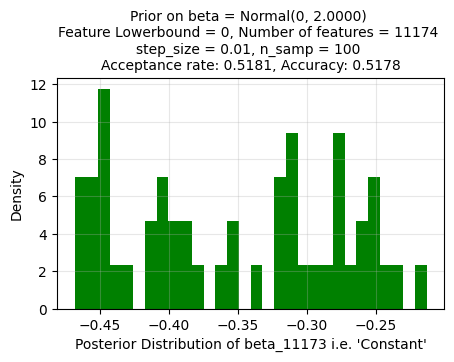

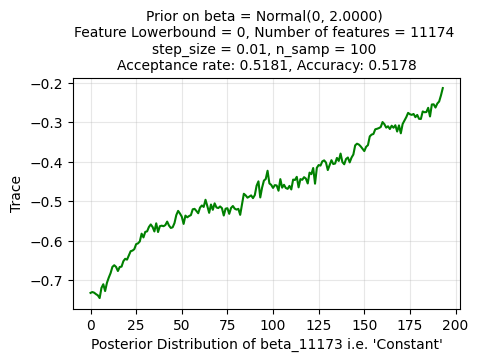

In [6]:
df = pd.read_csv('amazon_reviews.csv')
dataGenerator0 = DataGenerator(df, device='cuda', feature_lb = 0)
dataGenerator0.split_data(test_size=0.2, random_state=42)
model0 = ProperBayes(dataGenerator0, prior_mu=0, prior_std=np.sqrt(2))
model0.fit(step_size=0.01, n_samp=100, n_burnin=50)
model0.plot_hist('Constant')
model0.plot_trace('Constant')

Implementing proper bayes with feature selection

In [7]:
# Removing the words that occur less than in 1% of the reviews
dataGenerator1 = DataGenerator(df, device='cuda', feature_lb = 0.01)
dataGenerator1.split_data(test_size=0.2, random_state=42)


DataGenerator created : 
 Number of reviews : 4915 
 Number of features : 549 
 Number of words removed : 10625

Data split into train and test sets : 
 Train set size : 3932 
 Test set size : 983


In [9]:
# Fitting the model with a prior on beta = Normal(0, 2)
model1 = ProperBayes(dataGenerator1, prior_mu=0, prior_std=np.sqrt(2))
model1.fit(step_size=0.02, n_samp = 2000, n_burnin = 1000)


Select Count: 1, Chain Count: 1, time: 0.00 minutes
Select Count: 100, Chain Count: 223, time: 0.16 minutes
Select Count: 200, Chain Count: 418, time: 0.30 minutes
Select Count: 300, Chain Count: 669, time: 0.47 minutes
Select Count: 400, Chain Count: 894, time: 0.68 minutes
Select Count: 500, Chain Count: 1116, time: 0.90 minutes
Select Count: 600, Chain Count: 1383, time: 1.17 minutes
Select Count: 700, Chain Count: 1672, time: 1.41 minutes
Select Count: 800, Chain Count: 1948, time: 1.69 minutes
Select Count: 900, Chain Count: 2264, time: 2.00 minutes
Select Count: 1000, Chain Count: 2605, time: 2.26 minutes
Select Count: 1100, Chain Count: 2940, time: 2.62 minutes
Select Count: 1200, Chain Count: 3361, time: 3.00 minutes
Select Count: 1300, Chain Count: 3782, time: 3.53 minutes
Select Count: 1400, Chain Count: 4240, time: 3.99 minutes
Select Count: 1500, Chain Count: 4804, time: 4.39 minutes
Select Count: 1600, Chain Count: 5411, time: 4.82 minutes
Select Count: 1700, Chain Count:

Model takes very long to train when step_size increase beyond 0.03. We should shift to HMC that utilizes gradient information and is hence faster with smaller affordable rejection ratio.

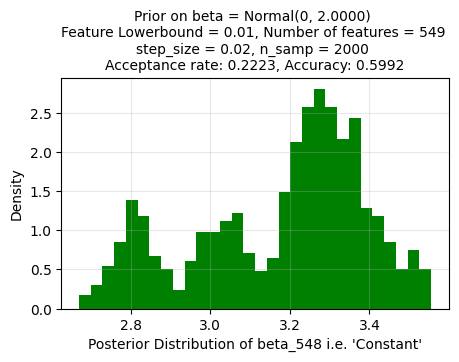

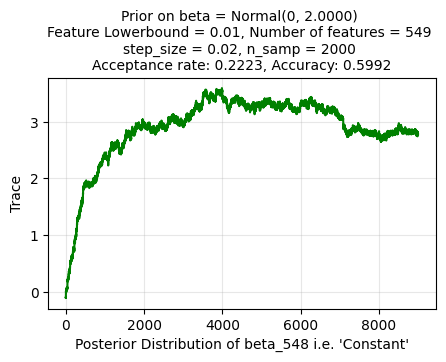

In [10]:
model1.plot_hist('Constant')
model1.plot_trace('Constant')

# Implementing HMC chain

In [11]:
df = pd.read_csv('amazon_reviews.csv')
dataGeneratorHMC = DataGenerator(df, device='cuda', feature_lb = 0.01)
dataGeneratorHMC.split_data(test_size=0.2, random_state=42)


DataGenerator created : 
 Number of reviews : 4915 
 Number of features : 549 
 Number of words removed : 10625

Data split into train and test sets : 
 Train set size : 3932 
 Test set size : 983


In [15]:
# Fitting the model with a prior on beta = Normal(0, 2)
modelHMC = ProperBayesHMC(dataGeneratorHMC, prior_mu=0, prior_std=np.sqrt(2))
modelHMC.fit(step_size=0.011, L = 1, n_samp = 1000, n_burnin = 500)

Accept Count: 1, Chain Count: 1, time: 0.00 minutes
Accept Count: 100, Chain Count: 183, time: 0.02 minutes
Accept Count: 200, Chain Count: 527, time: 0.06 minutes
Accept Count: 300, Chain Count: 925, time: 0.10 minutes
Accept Count: 400, Chain Count: 1562, time: 0.16 minutes
Accept Count: 500, Chain Count: 2076, time: 0.21 minutes
Accept Count: 600, Chain Count: 3314, time: 0.33 minutes
Accept Count: 700, Chain Count: 7121, time: 0.71 minutes
Accept Count: 800, Chain Count: 12524, time: 1.37 minutes
Accept Count: 900, Chain Count: 25118, time: 3.06 minutes


KeyboardInterrupt: 

In [66]:
modelHMC.save()

Model saved to HMC_step=0.01_L=1_n_samp=1000.pkl


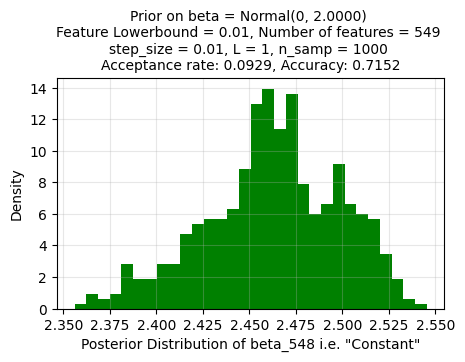

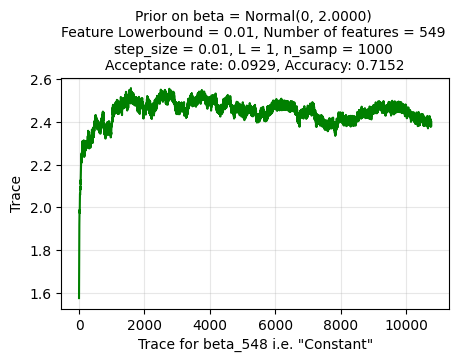

In [72]:
modelHMC.plot_hist('Constant')
modelHMC.plot_trace('Constant')

In [71]:
modelHMC.get_estimate('Constant')
modelHMC.get_estimate('good')
modelHMC.get_estimate('bad')
modelHMC.get_estimate('amazing')

Posterior estimate of beta_548 i.e. "Constant" : 2.4625
Posterior estimate of beta_264 i.e. "good" : 0.0353
Posterior estimate of beta_434 i.e. "bad" : 0.0698
Posterior estimate of beta_217 i.e. "amazing" : -0.8586


-0.8585845232009888

We observe that even at a small sample size and small step_size, HMC converges way more faster than MCMC.

Acceptance Rate of 61% was found at step_size=0.003 and L=1 in HMC for n_samp=500.